# Lab 2: adversarial training

Due date : February 25

Goals of the labs:
- Implement your first robust model
- Grab insights on what makes a model robust

Please note that some models can take a long time to train and be hard to debug. We have indicate the approximate runnig time of the corresponding cell. 

In [6]:
# linear.svg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## From adversarial examples to training robust models

In the previous lab, we focused on methods for solving the inner maximization problem over perturbations; that is, to finding the solution to the problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

In this lab we solve the min-max problem, which corresponds to the task of training a model that is robust to adversarial attacks. In other words, no matter what attack an adversary uses, we want to have a model that performs well.  That is, given some set of input/ouptput pairs $S$, we want to solve the outer minimization problem
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{|S|} \sum_{x,y \in S} \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
The order of the min-max operations is important here.  Specially, the max is inside the minimization, meaning that the adversary (trying to maximize the loss) gets to "move" _second_.  We assume, essentially, that the adversary has full knowledge of the classifier parameters $\theta$ (this was implicitly assumed throughout the entire previous section), and that they get to specialize their attack to whatever parameters we have chosen in the outer maximization.  The goal of the robust optimization formulation, therefore, is to ensure that the model cannot be attacked _even if_ the adversary has full knowledge of the model. 

The good news, in some sense, is that we already did a lot of the hard work in adversarial training, when we described various ways to approximately solve the inner maximization problem.  

## Adversarial training with adversarial examples

Perhaps the simplest strategy for training an adversarially robust model is also the one which seems most intuitive.  The basic idea (which originally was referred to as "adversarial training" in the machine learning literature, though is also basic technique from robust optimization when viewed through this lense) is to simply create and then incorporate adversarial examples into the training process.  In other words, since we know that "standard" training creates networks that are succeptible to adversarial examples, let's just _also_ train on a few adversarial examples.

Of course, the question arises as to _which_ adversarial examples we should train on. 
Supposing we generally want to optimize the min-max objective 
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{|S|} \sum_{x,y \in S} \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
using gradient descent, how do we do so?  If we want to simply optimize $\theta$ by stochastic gradient descent, this would simply involve computing repeatedly **computing** the gradient with respect to $\theta$ for the loss function on some minibatch, and taking a step in this negative direction.  That is, we want to repeat the update
\begin{equation}
\theta := \theta - \alpha \frac{1}{|B|} \sum_{x,y \in B} \nabla_\theta \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

How do we go about computing this inner gradient? The answer is given by Danskin's Theorem, which states that to compute the (sub)gradient of a function containing a max term, we need to simply 1) find the maximum, and 2) compute the normal gradient evaluated at this point.  In other words, the relevant gradient is given by
\begin{equation}
\DeclareMathOperator*{\argmax}{argmax}
\nabla_\theta \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y) = \nabla_\theta \ell(h_\theta(x + \delta^\star(x)), y)
\end{equation}
where 
\begin{equation}
\delta^\star(x) = \argmax_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

As we learned from the previous section, finding the maximum exactly is not an easy task.  And it is very difficult to say anything formally about the nature of the gradient if we do not solve the problem optimally.  Nonetheless, what we find in practice is the following: the "quality" of the robust gradient descent procedure is tied directly to how well we are able to perform the maximization.  In other words, the better job we do of solving the inner maximization problem, better our estimation of the inner gradient is.  In other words, _the key aspects of adversarial training is incorporate a strong attack into the inner maximization procedure_.  And projected gradient descent approaches (again, this included the simple variants like projected steepest descent) are the strongest attack that the community has found.

To recap, our strategy is the following:
\begin{equation}
\begin{split}
& \mbox{Repeat:} \\
& \quad \mbox{1. Select minibatch $B$, initialize gradient vector $g := 0$} \\
& \quad \mbox{2. For each $(x,y)$ in $B$:} \\
& \quad \quad \mbox{a. Find an attack perturbation $\delta^\star$ by (approximately) optimizing } \\
& \qquad \qquad \qquad \delta^\star = \argmax_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y) \\
& \quad \quad \mbox{b. Add gradient at $\delta^\star$} \\
& \qquad \qquad \qquad g:= g + \nabla_\theta \ell(h_\theta(x + \delta^\star), y) \\
& \quad \mbox{3. Update parameters $\theta$} \\
& \qquad \qquad \qquad \theta:= \theta - \frac{\alpha}{|B|} g
\end{split}
\end{equation}
Although this procedure approximately optimizes the robust loss, which is exactly the target we would like to optimize, in practice it is common to _also_ include a bit of the standard loss (i.e., also take gradient steps in the original data points), as this tends to also slightly improve the performance of the "standard" error of the task.  It is also common to randomize over the starting positions for PGD, or else there can be issues with the procedure learning loss surface such that the gradients exactly at the same points point in a "shallow" direction, but very nearby there are points that have the more typical steep loss surfaces of deep networks.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #

In [8]:
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_cnn = nn.Sequential(
      nn.Linear(784, 10)).to(device)

# Multiple ways of attacking

In [9]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=5, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [10]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


## Question 1 Implement a robust training algorithm

Implement the following robust training algorithm in the function $\texttt{epoch_adversarial}$
\begin{equation}
\begin{split}
& \mbox{Repeat:} \\
& \quad \mbox{1. Select minibatch $B$, initialize gradient vector $g := 0$} \\
& \quad \mbox{2. For each $(x,y)$ in $B$:} \\
& \quad \quad \mbox{a. Find an attack perturbation $\delta^\star$ by (approximately) optimizing } \\
& \qquad \qquad \qquad \delta^\star = \argmax_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y) \\
& \quad \quad \mbox{b. Add gradient at $\delta^\star$} \\
& \qquad \qquad \qquad g:= g + \nabla_\theta \ell(h_\theta(x + \delta^\star), y) \\
& \quad \mbox{3. Update parameters $\theta$} \\
& \qquad \qquad \qquad \theta:= \theta - \frac{\alpha}{|B|} g
\end{split}
\end{equation}

In [11]:

def epoch_adversarial(loader, model, attack=pgd_linf, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = pgd_linf(model, X, y)
        yp = model( X + delta )
        loss = nn.CrossEntropyLoss()( yp, y )
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

# Standard (i.e. non-robust) training on the logistic regression

In [7]:
# This cell should run in less than 3 minutes


model_logreg = nn.Sequential(
     Flatten(),
     nn.Linear(784, 10)).to(device)
opt = optim.SGD(model_logreg.parameters(), lr=1e-1)

print(*("{}".format(i) for i in ("Train Err", "Test Err", "Adv Err")), sep="\t")

for t in range(10):
    train_err, train_loss = epoch(train_loader, model_logreg, opt)
    test_err, test_loss = epoch(test_loader, model_logreg)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_logreg, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")

Train Err	Test Err	Adv Err


  0%|          | 0/10 [00:00<?, ?it/s]

0.133783	0.097800	0.389200
0.099067	0.089300	0.405500
0.092850	0.084800	0.430700
0.088050	0.081300	0.450600
0.085333	0.081400	0.458700
0.082850	0.081400	0.463600
0.082700	0.081300	0.464100
0.082717	0.081600	0.466000
0.082800	0.081300	0.467400
0.082567	0.081300	0.468800


## Question 2

What are the errors on the training set? The test set? The adversarial set? Comment.

The logistic regression is naturally trained, resulting in the following patterns in the loss:

1/ The train error is at 0.082, it decreases along the epochs which indicates that the regression is indeed learning a structure from the training dataset.

2/ The test error is at 0.081, it decreases as well indicating that the regression generalizes as well on a test set that has the same distribution as the train set.

3/ The train error and test error are in the same order which is excpected as the data comes from the same distribution

4/ The adversarial error is at 0.468, it is much higher than the test error. This is because the regression did not learn any robustness to attack and is hence highly sensitive to PGD attacks and classifies such examples poorly.

5/ The adversarial error increases along the training. In the natural training, the regression performs a minimization of the natural loss and not the adversarial loss. Therefore, it does not learn to mitigate the attacks. This explains why the adversarial loss increases. Indeed, the regression is learning a structure from the natural data. Therefore, its gradient and parameters become more and more informative. The PGD attack is a white-box attack that accesses the targeted regression's parameters. The attack gets more precise as the classifier's parameters get better. Therefore, in a natural training setting, it is expected to observe the adversarial loss increase while the natural loss decreases.

# Adversarial training on the logistic regression

In [12]:
# This cell should run in less than 3 minutes
model_logreg_robust = nn.Sequential(
     Flatten(),
     nn.Linear(784, 10)).to(device)
opt = optim.SGD(model_logreg_robust.parameters(), lr=1e-1)
print(*("{}".format(i) for i in ("Train Err", "Test Err", "Adv Err")), sep="\t")
for t in  range(10) :
    train_err, train_loss = epoch_adversarial(train_loader, model_logreg_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_logreg_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_logreg_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")

Train Err	Test Err	Adv Err


  0%|          | 0/10 [00:00<?, ?it/s]

0.300333	0.116600	0.261000
0.259883	0.109200	0.253100
0.255867	0.110900	0.247600
0.253867	0.108600	0.246600
0.253267	0.109500	0.246000
0.246850	0.109000	0.242800
0.246967	0.108100	0.244200
0.246967	0.108400	0.243900
0.246717	0.108900	0.242400
0.246933	0.108800	0.243900


## Question 3  

What are the errors on the training set? The test set? The adversarial set? Comment.

We perform adversarial training to the logistic regression, resulting in the following patterns in the loss:

1/ The train error is at 0.246, it decreases along the epochs which indicates that the regression is indeed learning a structure within the adversarial training task. Compared to the natural training task, the loss is a little more than two times higher, indicating that adversarial learning is a harder task yet with learnable structure.

2/ The test error is at 0.108, it decreases, indicating that the regression generalizes as well on a test set that has the same distribution as the natural train set Compared to natural training, we notice that the loss is a little more higher yet in the same order (around 0.1). This indicates adversarial training has a small influence on the generalization of the regression. This is an illutration of the robustness/generalization trade-off in adversarial learning.

3/ The test error is lower than the train error. This is expected because the test error is a simpler task compared to the adversarial training task.

4/ The adversarial error is at 0.243, it is more than two times higher than the test error case yet in the same order as the train error. Compared to the natural training case, the adversarial error is nearly 2 times smaller (it was at 0.46). This indicates an important improvement in the robustness of this regression to adversarial attacks.

5/ The adversarial error decreases along the training. In the adversarial training setting, the crafting of strong perturbations in the inner step (maximization) is then mitigated by the minimization task. The classifier is therefore learning to deal with adversarial examples. This is why the adversarial error decreases.

# Adversarial training on a simple CNN

In [17]:
# This cell should run in less than 15 minutes
model_simple_cnn_robust = nn.Sequential(
                                 nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(25088, 10)).to(device)
opt = optim.SGD(model_simple_cnn_robust.parameters(), lr=1e-1)
print(*("{}".format(i) for i in ("Train Err", "Test Err", "Adv Err")), sep="\t")
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_simple_cnn_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_simple_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_simple_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")

Train Err	Test Err	Adv Err
0.157250	0.049100	0.104000
0.081467	0.033100	0.077700
0.069283	0.025000	0.061600
0.062700	0.021900	0.058000
0.059883	0.021600	0.055200
0.049250	0.019400	0.051400
0.047967	0.020000	0.049200
0.048217	0.019500	0.050200
0.047300	0.020100	0.051000
0.046833	0.019300	0.050300


## Question 3  

What are the erorr on the training set? The test set? The adversarial set? Comment.

We perform adversarial training with a deep network, resulting in the following patterns in the loss:

1/ The train error is at 0.046, it decreases nearly by a factor of 3 between the begining and the end of the training. The CNN is learning a structure from the adversarial training task more efficiently than the linear regression. In comparison, the regression training loss only decreases of 0.05 points. This is because the CNN is a non-linear thus more expressive model that is able to capture more structure compared to a simple linear regression.

2/ The test error is at 0.019, it decreases, and is divided by 2 between the begining and end of training.  Compared to the regression, we notice that the loss is 5 times smaller. This is explained again by the superior generalization capability of a non-linear model. Also, we notice that the test error is smaller than the train error because the test error is an evaluation on a natural task that is easier compared to an adversarial task.

3/ The adversarial error is at 0.050. It is in the same order as the training error and it decreases along the training because the classifier is specifically learning to deal with adversarial examples.

5/ Both adversarial and natural losses seem to stagnate after epoch 7. I would suggest trying with a LR scheduler to see if we can obtain further loss decrease. Otherwise, this suggests a form of overfitting. Specific attention should be given to this phenomenon as overfitting in adversarial training was shown to be harmful to the performance (see L. Rice et. al. 2020 - https://arxiv.org/pdf/2002.11569.pdf)

# Evaluating robust models

We have pretrained larger CNN models (with better accuracy) for you, which are robust, and non-robust.
Now let us check if the models trained on larger CNN models yields better accuracy on adversarial examples.

In [12]:
model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)
model_cnn.load_state_dict(torch.load("model_cnn.pt", map_location=torch.device('cpu')))

model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)
model_cnn_robust.load_state_dict(torch.load("model_cnn_robust.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

Let's get a sense of this by evaluating our model against some different attacks.  Let's try FGSM first.

FGSM:  0.016


In [1]:
print("FGSM: ", epoch_adversarial(test_loader, model_cnn, fgsm)[0])
print("PGD, 5 iter: ", epoch_adversarial(test_loader, model_cnn, pgd_linf, num_iter=5)[0])

NameError: name 'epoch_adversarial' is not defined

## Quesiton 4

Comment the results.


1/ The error for FGSM attacks and PGD (K=5) is the same. This makes sense because FGSM attack is a special case of PGD with only 1 step and a step size of epsilon. 

2/ Because FGSM is a special case of PGD, we cannot conclude based on these results that adversarial training with PGD has brought robustness to other types of attacks, which would be a desirable property.

2/ The adversarial error for this larger model is lower than the one observed on a simple CNN because it was trained for longer and has more hyper-parameters (which helps in the robustness).

### What is happening with these robust models? 

So why do these models work well against robust attacks, and why have some other proposed methods for training robust models (in)famously come up short in this regard?  There are likely many answers to this question, but one potential answer can be seen by looking at the loss surface of the trained classifier.  Let's look at a projection of the loss function along two dimensions in the input space (one the direction of the actual gradient, and one a random direction).

In [8]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [9]:
def draw_loss(model, X, epsilon):
    Xi, Yi = np.meshgrid(np.linspace(-epsilon, epsilon,100), np.linspace(-epsilon,epsilon,100))
    
    def grad_at_delta(delta):
        delta.requires_grad_(True)
        nn.CrossEntropyLoss()(model(X+delta), y[0:1]).backward()
        return delta.grad.detach().sign().view(-1).cpu().numpy()

    dir1 = grad_at_delta(torch.zeros_like(X, requires_grad=True))
    delta2 = torch.zeros_like(X, requires_grad=True)
    delta2.data = torch.tensor(dir1).view_as(X).to(device)
    dir2 = grad_at_delta(delta2)
    np.random.seed(0)
    dir2 = np.sign(np.random.randn(dir1.shape[0]))
    
    all_deltas = torch.tensor((np.array([Xi.flatten(), Yi.flatten()]).T @ 
                              np.array([dir2, dir1])).astype(np.float32)).to(device)
    yp = model(all_deltas.view(-1,1,28,28) + X)
    Zi = nn.CrossEntropyLoss(reduction="none")(yp, y[0:1].repeat(yp.shape[0])).detach().cpu().numpy()
    Zi = Zi.reshape(*Xi.shape)
    #Zi = (Zi-Zi.min())/(Zi.max() - Zi.min())
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ls = LightSource(azdeg=0, altdeg=200)
    rgb = ls.shade(Zi, plt.cm.coolwarm)

    surf = ax.plot_surface(Xi, Yi, Zi, rstride=1, cstride=1, linewidth=0,
                       antialiased=True, facecolors=rgb)


Let's look at the loss surface for the standard network.

/tmp/ipykernel_29499/2255510583.py:24: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


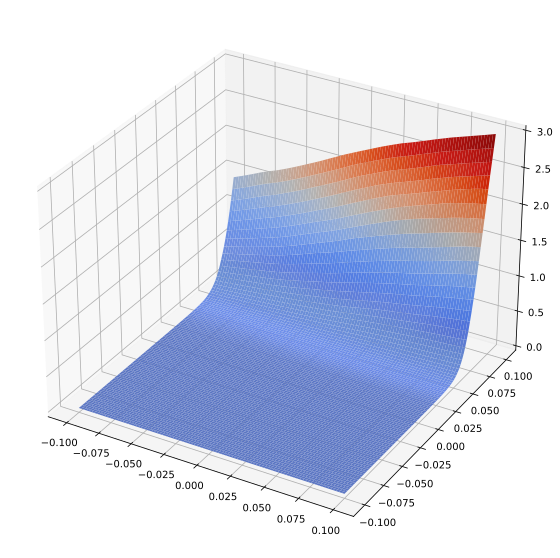

In [10]:
draw_loss(model_cnn, X[0:1], 0.1)

Very quickly the loss increases substantially.  Let's then compare this to the robust model.

/tmp/ipykernel_29499/2255510583.py:24: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


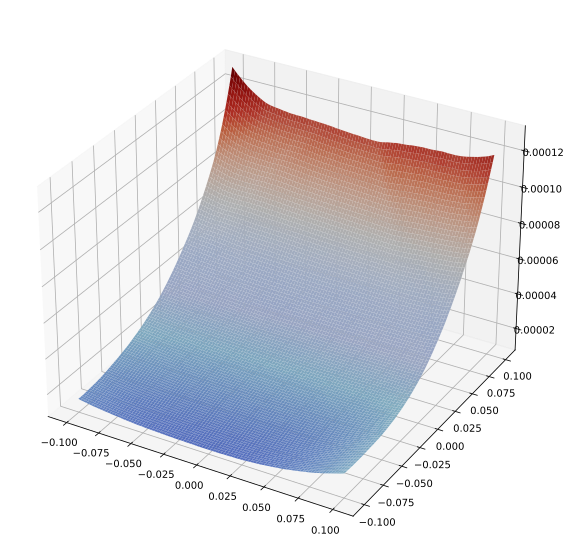

In [11]:
draw_loss(model_cnn_robust, X[0:1], 0.1)

## Question 5 (hard and almost open question)

Looking at the loss landscape of the robust and the non-robust model, can you provide an explanation of why the models are robust?

1/ The major difference between both loss landscapes is that the adversarially trained (2nd one) is smoother compared to the first one when evaluated on adversarial examples (see Grad_at_Delta function). In the same interval [-0.1,0.1] the loss surface of the naturally trained model (1st one) bumps to 3 whereas the one adversarially trained goes to 0.0012.

Here are my 3 analysis points:

2/ Other defences against adversarial attacks were developed such as gradient masking. These solutions hide the true direction of loss increase, they " result in a model that is very smooth in specific directions and neighborhoods of training points, which makes it harder for the adversary to find gradients indicating good candidate directions to perturb the input in a damaging way for the model " (Open AI blogspot). Therefore, the extra-smoothness obtained with adversarial training could be seen as an equivalent strategy taken by the model to smoothen as much as possible the curve to diminish the impact of white-box attacks that exploit the curves.

3/ A robust model can be seen as a model that has a good generalization error on an **adversarial dataset**. Following the regularization perpective, the smoother the loss landscape is, the better the generalization is. Therefore, a model that presents a smooth loss landscape on an adversarial dataset will better generalize on adversarial examples compared to a model with a bumpy/noisy landscape.

4/ In addition, adversarial training can be theoretically seen as a form of regularization. We have seen in class that adversarial training incentivizes model to focus on a smaller set of features called 'robust features' this would explain why the loss landscape is smoother.